# Generalized Autoregressive Conditional Heteroskedasticity (GARCH)
What is the goal of GARCH, and when do we use it? What requirements does the GARCH model have on the underlying data?

Write a little bit about what kind of input it expects. Primary goal volatility (time-varying variance). Energy consumption, therefore that is the main feature. Typically we use the residuals from a mean model like ARIMA to capture volatility dynamics.

The GARCH(1,1) model is a commonly used specification where both the autoregressive and moving average components are of order 1. The conditional volatility is a measure of time-varying volatility, which can be a valuable feature for forecasting future values of energy consumption, especially if you expect volatility clustering in your data.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from arch import arch_model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Set up data
morocco = pd.read_csv("../data/morocco.csv")

In [3]:
# A little processing
morocco['Consumption'] = morocco['Zone 1 Power Consumption'] + morocco['Zone 2  Power Consumption'] + morocco['Zone 3  Power Consumption']
morocco = morocco.drop(['Zone 1 Power Consumption','Zone 2  Power Consumption', 'Zone 3  Power Consumption'], axis=1)

morocco['DateTime'] = pd.to_datetime(morocco['DateTime'], format='%m/%d/%Y %H:%M')
morocco['year'] = morocco['DateTime'].dt.year
morocco['month'] = morocco['DateTime'].dt.month
morocco['day'] = morocco['DateTime'].dt.day
morocco['hour'] = morocco['DateTime'].dt.hour
morocco = morocco.drop(columns=['DateTime'])

In [4]:
# Fit ARIMA model to model the energy consumption data
# Optionally incorporate Temperature data as exogenous variable if we find significant relationship between these.

# Adjust p, d, q values based on your data analysis (e.g., ACF, PACF plots, stationarity tests, autocorrelation plots)
p, d, q = 1, 0, 1
model = SARIMAX(morocco['Consumption'], exog=morocco['Temperature'], order=(p, d, q))
results = model.fit(disp=False)

# Use the residuals as the input for the GARCH model.
# These residuals represent the unexplained part which might be influenced by volatility clustering.
print(results.summary())
residuals = results.resid

                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                52416
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -433431.333
Date:                Thu, 07 Mar 2024   AIC                         866870.666
Time:                        13:16:20   BIC                         866906.134
Sample:                             0   HQIC                        866881.752
                              - 52416                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature   238.3820     18.331     13.004      0.000     202.454     274.310
ar.L1           1.0000    5.1e-05   1.96e+04      0.000       1.000       1.000
ma.L1           0.6728      0.002    400.698    

In [5]:
# fitted to the residuals of the mean model to capture the volatility in energy consumption
garch_model = arch_model(residuals, p=1, q=1, mean='zero', vol='Garch', dist='normal')
garch_result = garch_model.fit(update_freq=5)
print(garch_result.summary())

# mean='zero indicates that we're modeling the variance of the residuals without a mean component
# as the mean has already been accoutned for in the first step.

Iteration:      5,   Func. Count:     24,   Neg. LLF: 423245.0233515512
Optimization terminated successfully    (Exit mode 0)
            Current function value: 423243.13268378197
            Iterations: 9
            Function evaluations: 39
            Gradient evaluations: 9
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -423243.
Distribution:                  Normal   AIC:                           846492.
Method:            Maximum Likelihood   BIC:                           846519.
                                        No. Observations:                52416
Date:                Thu, Mar 07 2024   Df Residuals:                    52416
Time:                        13:16:21   Df Model:                            0
         

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.814e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<Axes: >

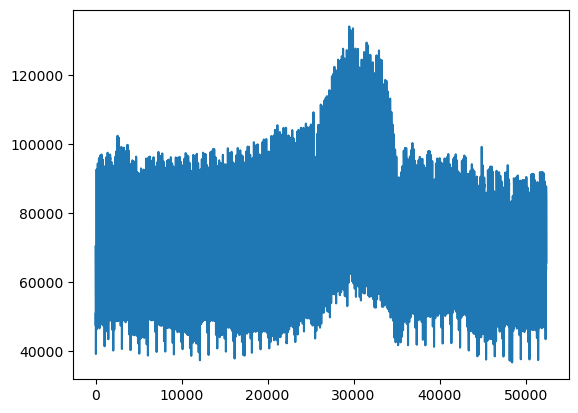

In [6]:
# Map underlying data
morocco['Consumption'].plot()

In [7]:
# Fitting a GARCH(1,1) model
# First, we'll model the residuals with a mean model (e.g., Constant Mean model)
# and then apply the GARCH(1,1) model to the residuals' variance.

time_series = morocco['Consumption']

# Here we are assuming that the residuals of your time series follow a normal distribution.
# You might want to test different distributions based on your data (e.g., 't', 'skewt')
garch_model = arch_model(time_series, vol='Garch', p=1, q=1, mean='constant', dist='normal')
model_result = garch_model.fit(update_freq=5)

print(model_result.summary())

# Extracting the conditional volatility
#morocco['conditional_volatility'] = model_result.conditional_volatility

Iteration:      5,   Func. Count:     27,   Neg. LLF: 557763.1738792369
Iteration:     10,   Func. Count:     52,   Neg. LLF: 557624.1036880374
Iteration:     15,   Func. Count:     77,   Neg. LLF: 557274.3695964024
Optimization terminated successfully    (Exit mode 0)
            Current function value: 557274.3695924178
            Iterations: 17
            Function evaluations: 87
            Gradient evaluations: 17
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Consumption   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -557274.
Distribution:                  Normal   AIC:                       1.11456e+06
Method:            Maximum Likelihood   BIC:                       1.11459e+06
                                        No. Observations:                52416
Date:                T

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


### Optimize parameters
GARCH(1,1) is a simple baseline variant of this implementation. In order to find the parameters suitable for our implementation we will use a brute force strategy to find the combination of p and q that minimizes the AIC. We will then visualize the results in a heatmap, where we will have p on the x-axis, q on the y-axis and log likelihood on the z-axis.

In [8]:
n=11

log_likelihoods = np.full((n, n), np.nan)  # Use np.nan for uninitialized values
aic_values = np.full((n, n), np.nan)

# Iterate over combinations of p and q values
for p in range(1, n):
    for q in range(1, n):
        try:
            # with warnings.catch_warnings():
            # warnings.filterwarnings("ignore", message="The optimizer returned code 8")
            # Fit GARCH model
            model = arch_model(time_series, p=p, q=q, mean='constant', vol='Garch', dist='normal')
            res = model.fit(disp='off', update_freq=5)
            # Store log likelihood and AIC
            log_likelihoods[p, q] = res.loglikelihood
            aic_values[p, q] = res.aic
        except:
            print(f"Model with p={p}, q={q} failed to converge")
            log_likelihoods[p, q] = np.nan
            aic_values[p, q] = np.nan

# Identifying the p, q with the minimum AIC
min_aic_index = np.unravel_index(np.nanargmin(aic_values), aic_values.shape)
print(f"Optimal p, q with minimum AIC: {min_aic_index}, AIC: {aic_values[min_aic_index]}")

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mar

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mar

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mar

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mar

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mar

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mar

Optimal p, q with minimum AIC: (1, 1), AIC: 1114556.7391848357


/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


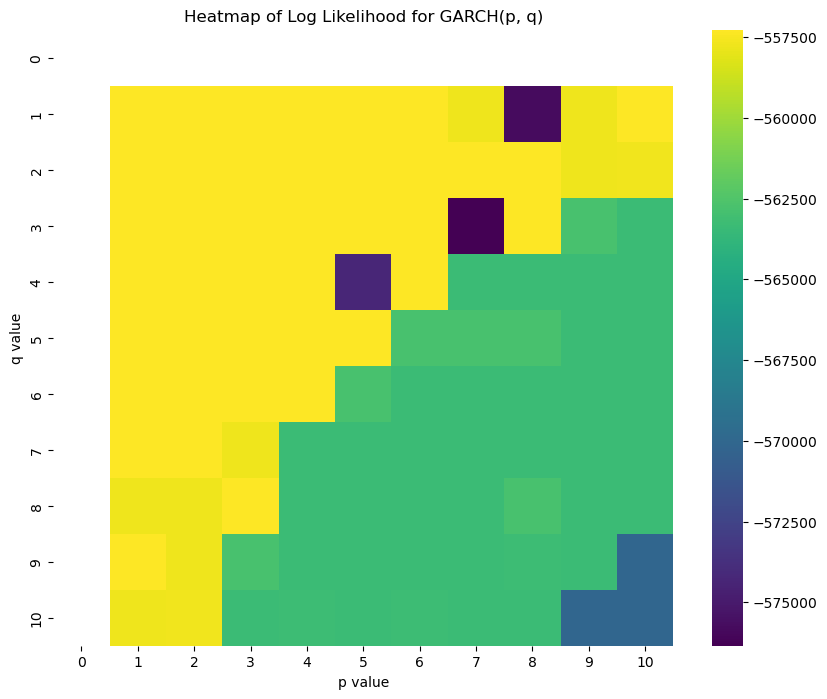

In [9]:
# Plotting the heatmap of log likelihood
plt.figure(figsize=(10, 8))
sns.heatmap(log_likelihoods, annot=True, fmt=".2f", cmap="viridis", xticklabels=range(11), yticklabels=range(11))
plt.title('Heatmap of Log Likelihood for GARCH(p, q)')
plt.xlabel('p value')
plt.ylabel('q value')
plt.show()

In [10]:
# GARCH model with the optimized values.
p,q = min_aic_index

garch_model = arch_model(time_series, vol='Garch', p=p, q=q, mean='constant', dist='normal')
model_result = garch_model.fit(update_freq=5)
print(model_result.summary())

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     77,   Neg. LLF: 557767.4092493616
Iteration:     10,   Func. Count:    154,   Neg. LLF: 1767124.920146285
Optimization terminated successfully    (Exit mode 0)
            Current function value: 557706.1510520496
            Iterations: 15
            Function evaluations: 169
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Consumption   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -557706.
Distribution:                  Normal   AIC:                       1.11544e+06
Method:            Maximum Likelihood   BIC:                       1.11556e+06
                                        No. Observations:                52416
Date:                Thu, Mar 07 2024   Df Residuals:                    52415
Time:         

In [11]:
# The params to use as features? I think we should use the actual conditional volatility.
model_result.params

mu          7.110500e+04
omega       5.877632e+06
alpha[1]    9.000000e-01
alpha[2]    0.000000e+00
beta[1]     0.000000e+00
beta[2]     0.000000e+00
beta[3]     0.000000e+00
beta[4]     0.000000e+00
beta[5]     0.000000e+00
beta[6]     0.000000e+00
beta[7]     0.000000e+00
beta[8]     0.000000e+00
beta[9]     0.000000e+00
beta[10]    0.000000e+00
Name: params, dtype: float64

### Discussion on GARCH
GARCH models can be sensitive to the choice of distribution for the residuals and the specification of the mean and variance equations. Depending on your specific dataset and hypothesis about the underlying process, you might need to adjust these settings for optimal performance.

In order to optimize the lagged values we use a brute force method where we try all combinations from 1 to 10 for both p and q. We want to minimize the AIC values, in which the brute force gave us the minimum AIC combination of p=2, q=10. A higher log likelihood suggests a better fit. 

Based on the plot it looks like the best p,q values are (8,10), (10,9) or (10,4). This discrepancy between the model with the minimum AIC and the one with the highest log likelihood can be a result of the AIC not only consider the goodness of fit via the log likelihood, but also penalizes the more complex models, that is the ones with the higher number of parameters, to discourage overfitting. A model with a higher log likelihood which also has more parameters might have a higher/ worse AIC than a simpler model with a slightly lower log likelihood, which is likely what we observe in this case.

The optimal model depends on the criteria in which we prioritizes. If our goal is purely to maximize the fit without regard to model complexity, the highest log likelihood model might be preferred. However, for general predictive performance and to avoid overfitting, the model with the lowest AIC is often chosen. This is because the AIC aims to find a model that explains the data well with as few parameters as possible, improving generalizability.

These results should bevalidated on out-of-sample tests to see if the advantages of AIC and log likelihood translate into practical forecasting performance.

Enhancements
* Initial Parameter Guesses - Improve convergence by starting from a better position. Requires good understanding.
* Model simplify - Reduce the complexity (number of parameters) to avoid convergence issues (like I encountered)
* Increate tolerence and iteration limits - make it less strict by giving the algo more room to find solution. options={'maxiter': X, 'ftol': Y} in the fit function.
* Ensure the data is stationary as non-stationary data can lead to convergence issues.

In order to improve the predictive models, we can use the results from the GARCH analysis to create an additional volatility feature, which might capture aspects of the underlying data that are related to temporal variability not directly observable through the original features.

Stick to AIC. the plot is log likelihood

In [1]:
conditional_volatility = model_result.conditional_volatility
morocco['conditional_volatility'] = conditional_volatility.values

NameError: name 'model_result' is not defined

ARMA vs. GARCH vs. ARMA GARCH  
Check if LSTM and Transformers outperform these (basically without the features)  
